<a href="https://colab.research.google.com/github/shazzad-hasan/deep-learning-from-first-principles/blob/main/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!git clone https://github.com/shazzad-hasan/deep-learning-from-first-principles.git

Cloning into 'deep-learning-from-first-principles'...
remote: Enumerating objects: 264, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 264 (delta 9), reused 237 (delta 0), pack-reused 0
Receiving objects: 100% (264/264), 5.17 MiB | 38.67 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/deep-learning-from-first-principles/cat_vs_dog

/content/deep-learning-from-first-principles/cat_vs_dog


In [4]:
!ls

test  train


## Load and visualize the dataset

In [5]:
# import requird libraries
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

In [6]:
train_dir = 'train/'
test_dir = 'test/'

train_images = [train_dir+i for i in os.listdir(train_dir)]
test_images =  [test_dir+i for i in os.listdir(test_dir)]

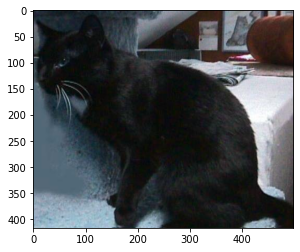

In [7]:
# plot a training example
index = 7
img = cv2.imread(train_images[index])
plt.imshow(img)

In [11]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (rows, columns), interpolation=cv2.INTER_CUBIC)

In [12]:
rows = 64
columns = 64
channels = 3

def prepare_data(images):
    m = len(images)
    X = np.zeros((m, rows, columns, channels), dtype=np.uint8)
    y = np.zeros((1, m))
    for i, image_file in enumerate(images):
        X[i,:] = read_image(image_file)
        if 'dog' in image_file.lower():
            y[0, i] = 1
        elif 'cat' in image_file.lower():
            y[0, i] = 0
    return X, y

In [13]:
train_x, train_y = prepare_data(train_images)
test_x, test_y = prepare_data(test_images)

m_train = train_x.shape[0]
m_test = test_x.shape[0]
num_px = train_x.shape[1]

print ("Number of training images = " + str(m_train))
print ("Number of testing images= " + str(m_test))
print ("Image dimension (h,w,c): (" + str(num_px) + ", " + str(num_px) + ", 3)")

Number of training images = 202
Number of testing images= 30
Image dimension (h,w,c): (64, 64, 3)


In [14]:
train_x_flatten = train_x.reshape(train_x.shape[0], -1).T
test_x_flatten = test_x.reshape(test_x.shape[0], -1).T

train_set_x = train_x_flatten/255
test_set_x = test_x_flatten/255

In [15]:
print ("train_set_x_flatten shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_y.shape))

train_set_x_flatten shape: (12288, 202)
train_set_y shape: (1, 202)
test_set_x_flatten shape: (12288, 30)
test_set_y shape: (1, 30)


## Define a model

In [16]:
def sigmoid(z):
  """ returns sigmoid of z"""
  s = 1/(1+np.exp(-z))
  return s

In [17]:
def initialize_with_zeros(d):
  """ Inilitize the model parameters (w,b) with zeros"""
  w = np.zeros((d,1))
  b = 0
  return w, b

In [18]:
def propagation(w, b, X, Y):
  """ Implement the cost function and it's gradients"""
  
  m = X.shape[1]

  # forward propagation
  z = np.dot(w.T, X) + b
  A = sigmoid(z)

  loss = [(Y[0][i] * np.log(A[0][i]) + (1-Y[0][i]) * np.log(1-A[0][i]))  for i in range(m)]
  cost = (-1/m) * np.sum(loss)  
  
  # backpropagation
  dw = (1/m) * np.dot(X, (A-Y).T)
  db = (1/m) * np.sum((A-Y))

  cost = np.squeeze(cost)
  gradients = {"dw":dw, "db":db}

  return cost, gradients

In [19]:
def optimize(w, b, X, Y, learning_rate, num_iterations):
  """ Optimize w, b by Gradient Descent (GD) algorithm """
  costs = []

  for i in range(num_iterations):
    cost, gradients = propagation(w, b, X, Y)

    # retrive derivatives
    dw = gradients["dw"]
    db = gradients["db"]

    # GD update rule
    w -= learning_rate * dw
    b -= learning_rate * db

    # record the cost per 100 iterations
    if i % 100 == 0:
      costs.append(cost)

    if i % 100 == 0:
      print("Cost after iteration %i: %f" %(i, cost))  

  parameters = {"w": w, "b": b}
  gradients = {"dw": dw, "db": db}

  return parameters, gradients, costs

In [20]:
def predict(w, b, X):
  """ Takes in learned logistic regression parameters (w,b)
      and returns a vector containing all predictions for 
      the examples in X.
  """
  m = X.shape[1]
  predicted_Y = np.zeros((1,m))

  w = w.reshape(X.shape[0],1)
  z = np.dot(w.T, X) + b
  A = sigmoid(z)

  # convert probabilities A[0][i] to actual predictions
  for i in range(A.shape[1]):
    if A[0, i] > 0.5:
      predicted_Y[0, i] = 1
    else:
      predicted_Y[0, i] = 0
      
  return predicted_Y

In [21]:
def model(train_x, train_y, test_x, test_y, num_iterations = 2000, learning_rate = 0.5):
    """ Builds the logistic regression model and returns a dictionary containing 
        informations about the model.
    """
    
    # initialize parameters with zeros
    w, b = initialize_with_zeros(train_x.shape[0])
    
    # gradient descent
    parameters, grads, costs = optimize(w, b, train_x, train_y, learning_rate, num_iterations)
    
    # retrieve weights and biases
    w = parameters["w"]
    b = parameters["b"]
    
    # predict train and test set examples
    train_prediction_y = predict(w, b, train_x)
    text_prediction_y = predict(w, b, test_x)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(train_prediction_y - train_y)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(text_prediction_y - test_y)) * 100))

    # create a dic containing informations about the model
    d = {"costs": costs,
         "train_prediction_y" : train_prediction_y,
         "text_prediction_y": text_prediction_y, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

## Train the model

In [26]:
# train the model
d = model(train_set_x, train_y, test_set_x, test_y, num_iterations = 3000, learning_rate = 0.001)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.642238
Cost after iteration 200: 0.605680
Cost after iteration 300: 0.575357
Cost after iteration 400: 0.549133
Cost after iteration 500: 0.525964
Cost after iteration 600: 0.505196
Cost after iteration 700: 0.486378
Cost after iteration 800: 0.469181
Cost after iteration 900: 0.453357
Cost after iteration 1000: 0.438713
Cost after iteration 1100: 0.425097
Cost after iteration 1200: 0.412384
Cost after iteration 1300: 0.400473
Cost after iteration 1400: 0.389277
Cost after iteration 1500: 0.378726
Cost after iteration 1600: 0.368757
Cost after iteration 1700: 0.359318
Cost after iteration 1800: 0.350364
Cost after iteration 1900: 0.341853
Cost after iteration 2000: 0.333750
Cost after iteration 2100: 0.326025
Cost after iteration 2200: 0.318648
Cost after iteration 2300: 0.311596
Cost after iteration 2400: 0.304846
Cost after iteration 2500: 0.298378
Cost after iteration 2600: 0.292172
Cost after iteration 2700: 0.286214
Cost

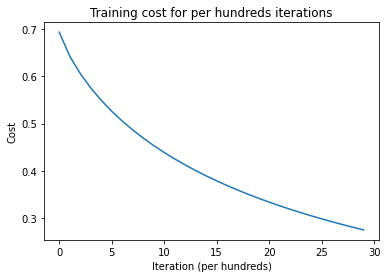

In [27]:
# plot learning curve with costs
costs = np.squeeze(d["costs"])
plt.plot(costs)
plt.xlabel("Iteration (per hundreds)")
plt.ylabel("Cost")
plt.title("Training cost for per hundreds iterations")
plt.show()

## Evaluate the performance of our trained model on a test dataset!